# Diffusion-deformation theories for hydrogels

Author: Jorge Urrea - 2024.01.17

## Introduction

We solve the transient nonlinear chemoelastic problem presented by Liu et al. (2016) using Fenics. This model describes the swelling kinetics of polymer gels. In this model both fields are fully coupled and it is assumed that the evolution is quasi-static, thus, the inertial effects are neglected. A staggered approach is adopted.

In [1]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Model setup
L = 0.01  # length of the plate
N = 10  # mesh density

# mesh = UnitSquareMesh(N,N)
mesh = UnitCubeMesh(N, N, N)

# Scale the mesh to the desired domain size
coordinates = mesh.coordinates()
for coord in coordinates:
    coord *= L

In [3]:
#Defining the model parameters
µ_o = -5.71#-0.3124 # initial chemical potential
µ_dry = -1.897 # chemical potential when material is dry
µ_swell = 0 # chemical potential when material is swollen and in equilibrium

µ_diff = 0.0 # chemical potential difference (µ - µ_o) (µ = µ_swell when gel is swollen)

In [4]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [5]:
### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_mu = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
W = FunctionSpace(mesh, MixedElement([element_u, element_mu]))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [6]:
# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = 0.0                 # uy
        values[3] = µ_o #-0.3124        # mu
    def value_shape(self):
        return (4,)

In [7]:
# defining the front boundary of the 3D block
def front(x, on_boundary):
    return near(x[1], 0) and on_boundary
# defining the back boundary of the 3D block
def back(x, on_boundary):
    return near(x[1], L) and on_boundary
# defining the top boundary of the 3D block
def top(x, on_boundary):
    return near(x[2], L) and on_boundary
# defining the bottom boundary of the 3D block
def bottom(x, on_boundary):
    return near(x[2], 0) and on_boundary
# defining the left boundary of the 3D block
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary
# defining the right boundary of the 3D block
def right(x, on_boundary):
    return near(x[0], L) and on_boundary

In [8]:
# zero displacement boundary conditions on the symmetric part of the plate
u_bc_front = DirichletBC(W.sub(0).sub(1), Constant(0.0), front)
u_bc_left = DirichletBC(W.sub(0).sub(0), Constant(0.0), left)
u_bc_bottom = DirichletBC(W.sub(0).sub(2), Constant(0.0), bottom) 

# chemical potential on the outer boundaries
mu_bc_back = DirichletBC(W.sub(1), Constant(µ_swell), back)
mu_bc_right = DirichletBC(W.sub(1), Constant(µ_swell), right)
mu_bc_top = DirichletBC(W.sub(1), Constant(µ_swell), top)

bcs = [u_bc_front, u_bc_left, u_bc_bottom, mu_bc_back, mu_bc_right, mu_bc_top]
# bcs = [u_bc_bottom, u_bc_right, mu_bc_top, mu_bc_left]
# bcs = [u_bc_bottom, u_bc_left, mu_bc_top, mu_bc_right]
# bcs = [u_bc_bottom, u_bc_left, u_bc_right, mu_bc_top]

In [9]:
dU = TrialFunction(W)
(du, dµ) = split(dU)

V_ = TestFunction(W)
(v, q) = split(V_)

U = Function(W)
(u, µ) = split(U)

Uold = Function(W)
(uold, µold) = split(Uold)

# Create intial conditions and interpolate
u_init = InitialConditions()
Uold.interpolate(u_init)

Kinematic quantities

In [10]:
# Model parameters
# Elasticity parameters
# G0, χ = Constant(1.7e7), Constant(0.4)#Constant(0.2)
χ = Constant(0.2)
NΩ = Constant(1e-3) # => N approx 1e20
Ω = Constant(1.7e-28)                          # the volume per solvent molecule
kBT = Constant(1.3806488e-23*298)              # T = 298 K
NkBT = Constant(1e25*1.3806488e-23*298)
D = Constant(0.2)#Constant(2e-4)#Constant(7.4e-11)                          # species diffusivity m^2 s^-1
mc = Constant(0.1)

In [11]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)                         # Identity tensor

def F(u):
    return variable(I + grad(u)) 

# F = variable(I + grad(u))               # Deformation gradient
# C = F.T*F                             # Right Cauchy-Green tensor

# Left Cauchy-Green tensor
def B(u):
    return variable(F(u)*F(u).T)

# Invariants of deformation tensors
def Ic(u):
    return variable(tr(F(u).T*F(u)))
 
# Ic = tr(F(u).T*F(u))

def J(u):
    return variable(det(F(u)))

# J  = (det(F)) #1 + Ω*C

In [12]:
# Elasticity parameters
E, nu = 70e3, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))
G0 = Constant(1e7)#Constant(40e3)#Constant(1e7/(1e25*1.3806488e-23*298))
print(E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model + chem potential)
def psi(u,µ): 
    return variable((G0/2)*(Ic(u) - 3 - 2*ln(J(u))) + (kBT/Ω)*((J(u) - 0.999)*ln(1 - 0.999/J(u)) + χ*(1 - 0.999/J(u)))  - kBT*(µ/Ω)*(J(u) -1)) 

40384.61538461538


In [13]:
# first Kirchooff stress - PK1 
def p_mu(u,µ):
    return variable(-µ/(Ω) + 1/Ω*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2)))

def sigma(u,µ):
    return variable(p_mu(u,µ)*I + inv(J(u))*(G0)*(B(u) - I))

def PK1(u,µ):
    return variable(((G0)*(B(u) - I) + J(u)*(-µ + kBT/Ω*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2)))*I)*inv(F(u).T))

In [14]:
dt = Constant(0.)

quadrature_degree = 4
dx = dolfin.Measure('dx', domain=mesh, metadata={'quadrature_degree': quadrature_degree})

# Total potential energy
Psi_n = psi(u,µ)*dx# - inner(T, u)*ds
Pi_mech = derivative(Psi_n, u, v) 

Jac_mech = derivative(Pi_mech, u, du) + derivative(Pi_mech, µ, dµ)

D = 7e-5*kBT 
def mr(u):
    return variable(J(u)*(D/kBT)*inv(B(u))) 

# Mass balance
Pi_chem = (
            (inner(J(u)*grad(u - uold),inv(F(u).T))*q)*dx 
            + dt*inner(mr(u)*grad(µ),grad(q))*dx)

Pi = Pi_mech + Pi_chem 

Jac_chem = derivative(Pi_chem, u, du) + derivative(Pi_chem, µ, dµ) 

Jac = Jac_mech + Jac_chem

In [15]:
def plot_displacement(u, t_current, plane, num_points=10, scale_factor=1):

    # Create a 2D grid of points in the specified plane
    if plane == 'xy':
        z_plane = L
        x_grid, y_grid = np.linspace(0, L, num_points), np.linspace(0, L, num_points)
        X, Y = np.meshgrid(x_grid, y_grid)
        U = np.array([[u(x, y, z_plane)[0] for x in x_grid] for y in y_grid])
        V = np.array([[u(x, y, z_plane)[1] for x in x_grid] for y in y_grid])
        W = np.array([[u(x, y, z_plane)[2] for x in x_grid] for y in y_grid])
    elif plane == 'xz':
        y_plane = L
        x_grid, z_grid = np.linspace(0, L, num_points), np.linspace(0, L, num_points)
        X, Z = np.meshgrid(x_grid, z_grid)
        U = np.array([[u(x, y_plane, z)[0] for x in x_grid] for z in z_grid])
        V = np.array([[u(x, y_plane, z)[1] for x in x_grid] for z in z_grid])
        W = np.array([[u(x, y_plane, z)[2] for x in x_grid] for z in z_grid])
    elif plane == 'yz':
        x_plane = L
        y_grid, z_grid = np.linspace(0, L, num_points), np.linspace(0, L, num_points)
        Y, Z = np.meshgrid(y_grid, z_grid)
        U = np.array([[u(x_plane, y, z)[0] for y in y_grid] for z in z_grid])
        V = np.array([[u(x_plane, y, z)[1] for y in y_grid] for z in z_grid])
        W = np.array([[u(x_plane, y, z)[2] for y in y_grid] for z in z_grid])
    else:
        raise ValueError('Invalid projection plane. Must be one of: "xy", "xz", "yz"')

    # Deform the original grid using the displacement vectors scaled by the scale factor
    if plane == 'xy':
        X_deformed = X + scale_factor * U
        Y_deformed = Y + scale_factor * V
    elif plane == 'xz':
        X_deformed = X + scale_factor * U
        Z_deformed = Z + scale_factor * W
    elif plane == 'yz':
        Y_deformed = Y + scale_factor * V
        Z_deformed = Z + scale_factor * W

    # Plot the deformed grid on the specified plane
    fig, ax = plt.subplots(figsize=(6,5))

    # Create a scatter plot of the deformed points with color proportional to the displacement magnitude
    if plane == 'xy':
        magnitudes = np.sqrt(U**2 + V**2 + W**2)
        sc = ax.scatter(X_deformed, Y_deformed, c=magnitudes, cmap='viridis')
    elif plane == 'xz':
        magnitudes = np.sqrt(U**2 + V**2 + W**2)
        sc = ax.scatter(X_deformed, Z_deformed, c=magnitudes, cmap='viridis')
    elif plane == 'yz':
        magnitudes = np.sqrt(U**2 + V**2 + W**2)
        sc = ax.scatter(Y_deformed, Z_deformed, c=magnitudes, cmap='viridis')

    # Set plot labels and axis limits
    if plane == 'xy':
        ax.set_xlabel("$X$-coord. [m]", fontsize=16)
        ax.set_ylabel("$Y$-coord. [m]", fontsize=16)
    elif plane == 'xz':
        ax.set_xlabel("$X$-coord. [m]", fontsize=16)
        ax.set_ylabel("$Z$-coord. [m]", fontsize=16)
    elif plane == 'yz':
        ax.set_xlabel("$Y$-coord. [m]", fontsize=16)
        ax.set_ylabel("$Z$-coord. [m]", fontsize=16)

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim(-0.0005, 0.014)
    ax.set_ylim(-0.0005, 0.014)
    ax.set_title("deformed gel ($t = {:.1f}$ [s])".format(t_current), fontsize = 14)
    
    x_ticks = np.linspace(0, 0.01, 3)  # 5 ticks from 0 to 0.01
    y_ticks_disp = np.linspace(0, 0.014, 4)  # Example for the lambda_res subplot
    ax.set_xticks(x_ticks)
    # ax.set_yticks(y_ticks_disp)

    # Add a colorbar to show the displacement magnitudes
    # plt.colorbar(sc, ax=ax, label='Displacement magnitude')
    # cbar = plt.colorbar(sc, ax=ax)#, shrink = 0.5)
    # cbar.ax.tick_params(labelsize=14)

    # Adjust the margins
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

    # filename = f"results/Liu/time/Fig_3DFEM_def_gel_x001_{plane}_{t_current:.1f}.pdf"
    # plt.savefig(filename)
    plt.show()

In [16]:
Nincr = 10
t = np.linspace(0, 10, Nincr+1)
Nx = 10
x = np.linspace(0, L, Nx)
µ_res = np.zeros((Nx, Nincr+1))

Jx_array = np.zeros((Nx, Nincr+1))

lambda0_array = np.zeros((Nx, Nincr+1))
lambdaL_array = np.zeros((Nx, Nincr+1))

sigmaxx0_array = np.zeros((Nx, Nincr+1))
sigmaxxL_array = np.zeros((Nx, Nincr+1))

sigma_y_array = np.zeros((Nx, Nincr+1))

PK1xx0_array = np.zeros((Nx, Nincr+1))
PK1xxL_array = np.zeros((Nx, Nincr+1))

S = FunctionSpace(mesh, element_mu)

for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    t_current = t[i+1]
    print("t =", t_current) 
    dt.assign(dti)
 
    solve(Pi == 0, U, bcs, J = Jac, solver_parameters={"newton_solver":
                                        {"convergence_criterion": "incremental","maximum_iterations": 20}})
        #     {"relative_tolerance": 1e-6, "linear_solver": "gmres", "convergence_criterion": "incremental", "relaxation_parameter": 0.9}})
    Uold.assign(U)
    
    (u, µ) = U.split()

    µ_res[:, i+1] = [µ(L/2,L/2, xi) for xi in x]

    Jx0 = J(u)**(1/2)
    Jx0_P1 = project(Jx0, S)
    Jx_array[:, i+1] = [Jx0_P1(L, xi, L) for xi in x] 
    lambda0_array[:, i+1] = [Jx0_P1(L,0.0, xi) for xi in x]
    lambdaL_array[:, i+1] = [Jx0_P1(L/2,L/2, xi) for xi in x]

    sigmaxx = sigma(u,µ)[0,0]/NkBT
    sigmaxx_P1 = project(sigmaxx, S)
    sigmaxx0_array[:, i+1] = [sigmaxx_P1(L/2,0.0, xi) for xi in x] 
    sigmaxxL_array[:, i+1] = [sigmaxx_P1(L/2,L/2, xi) for xi in x]  

    sigma_y = p_mu(u,µ)
    sigma_y_P1 = project(sigma_y, S)
    sigma_y_array[:, i+1] = [sigma_y_P1(L/2,L/2, xi) for xi in x]   

    PK1xx = PK1(u,µ)[0,0]
    PK1xx_P1 = project(PK1xx, S)
    PK1xx0_array[:, i+1] = [PK1xx_P1(L,0.0, xi) for xi in x] 
    PK1xxL_array[:, i+1] = [PK1xx_P1(L,L, xi) for xi in x]

    # plot_displacement(u, t_current, 'xy', num_points=100)
    # plot_displacement(u, t_current, 'xz', num_points=100)
    # plot_displacement(u, t_current, 'yz', num_points=100)

    

Increment 1
t = 1.0
Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.933e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.355e-01 (tol = 1.000e-10) r (rel) = 4.621e+00 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.355e-01 (tol = 1.000e-10) r (rel) = 1.485e+01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 9.755e-01 (tol = 1.000e-10) r (rel) = 3.326e+01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.334e+00 (tol = 1.000e-10) r (rel) = 4.547e+01 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 7.627e-01 (tol = 1.000e-10) r (rel) = 2.600e+01 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 8.764e-02 (tol = 1.000e-10) r (rel) = 2.988e+00 (tol = 1.000e-09)
  Newton it

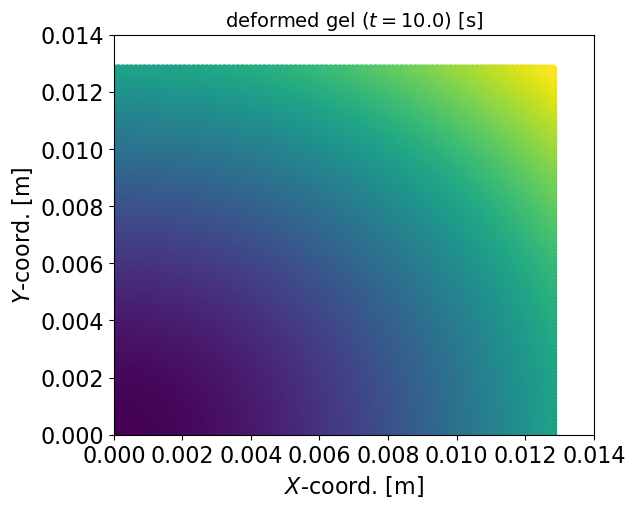

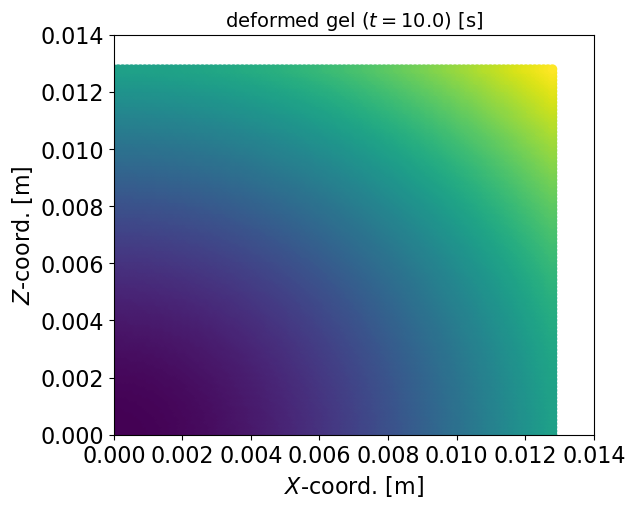

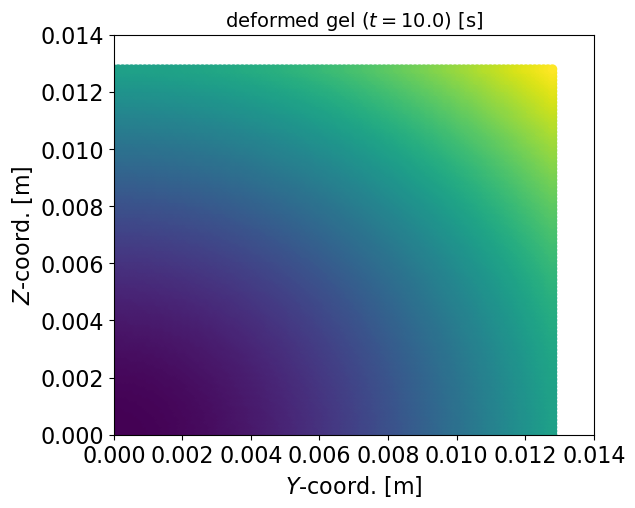

In [17]:
def plot_displacement(u, t_current, plane, num_points=10, scale_factor=1):

    # Create a 2D grid of points in the specified plane
    if plane == 'xy':
        z_plane = L
        x_grid, y_grid = np.linspace(0, L, num_points), np.linspace(0, L, num_points)
        X, Y = np.meshgrid(x_grid, y_grid)
        U = np.array([[u(x, y, z_plane)[0] for x in x_grid] for y in y_grid])
        V = np.array([[u(x, y, z_plane)[1] for x in x_grid] for y in y_grid])
        W = np.array([[u(x, y, z_plane)[2] for x in x_grid] for y in y_grid])
    elif plane == 'xz':
        y_plane = L
        x_grid, z_grid = np.linspace(0, L, num_points), np.linspace(0, L, num_points)
        X, Z = np.meshgrid(x_grid, z_grid)
        U = np.array([[u(x, y_plane, z)[0] for x in x_grid] for z in z_grid])
        V = np.array([[u(x, y_plane, z)[1] for x in x_grid] for z in z_grid])
        W = np.array([[u(x, y_plane, z)[2] for x in x_grid] for z in z_grid])
    elif plane == 'yz':
        x_plane = L
        y_grid, z_grid = np.linspace(0, L, num_points), np.linspace(0, L, num_points)
        Y, Z = np.meshgrid(y_grid, z_grid)
        U = np.array([[u(x_plane, y, z)[0] for y in y_grid] for z in z_grid])
        V = np.array([[u(x_plane, y, z)[1] for y in y_grid] for z in z_grid])
        W = np.array([[u(x_plane, y, z)[2] for y in y_grid] for z in z_grid])
    else:
        raise ValueError('Invalid projection plane. Must be one of: "xy", "xz", "yz"')

    # Deform the original grid using the displacement vectors scaled by the scale factor
    if plane == 'xy':
        X_deformed = X + scale_factor * U
        Y_deformed = Y + scale_factor * V
    elif plane == 'xz':
        X_deformed = X + scale_factor * U
        Z_deformed = Z + scale_factor * W
    elif plane == 'yz':
        Y_deformed = Y + scale_factor * V
        Z_deformed = Z + scale_factor * W

    # Plot the deformed grid on the specified plane
    fig, ax = plt.subplots(figsize=(6,5))

    # Create a scatter plot of the deformed points with color proportional to the displacement magnitude
    if plane == 'xy':
        magnitudes = np.sqrt(U**2 + V**2 + W**2)
        sc = ax.scatter(X_deformed, Y_deformed, c=magnitudes, cmap='viridis')
    elif plane == 'xz':
        magnitudes = np.sqrt(U**2 + V**2 + W**2)
        sc = ax.scatter(X_deformed, Z_deformed, c=magnitudes, cmap='viridis')
    elif plane == 'yz':
        magnitudes = np.sqrt(U**2 + V**2 + W**2)
        sc = ax.scatter(Y_deformed, Z_deformed, c=magnitudes, cmap='viridis')

    # Set plot labels and axis limits
    if plane == 'xy':
        ax.set_xlabel("$X$-coord. [m]", fontsize=16)
        ax.set_ylabel("$Y$-coord. [m]", fontsize=16)
    elif plane == 'xz':
        ax.set_xlabel("$X$-coord. [m]", fontsize=16)
        ax.set_ylabel("$Z$-coord. [m]", fontsize=16)
    elif plane == 'yz':
        ax.set_xlabel("$Y$-coord. [m]", fontsize=16)
        ax.set_ylabel("$Z$-coord. [m]", fontsize=16)

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim(0, 0.014)
    ax.set_ylim(0, 0.014)
    ax.set_title("deformed gel ($t = {:.1f}$) [s]".format(t_current), fontsize = 14)

    # Add a colorbar to show the displacement magnitudes
    # plt.colorbar(sc, ax=ax, label='Displacement magnitude')
    # cbar = plt.colorbar(sc, ax=ax)#, shrink = 0.5)
    # cbar.ax.tick_params(labelsize=14)

    # Adjust the margins
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

    # filename = f"results/Liu/time/Fig_3DFEM_def_gel_x001_{plane}_{t_current:.1f}.pdf"
    # plt.savefig(filename)
    plt.show()

plot_displacement(u, 10, 'xy', num_points=100)
plot_displacement(u, 10, 'xz', num_points=100)
plot_displacement(u, 10, 'yz', num_points=100)

110


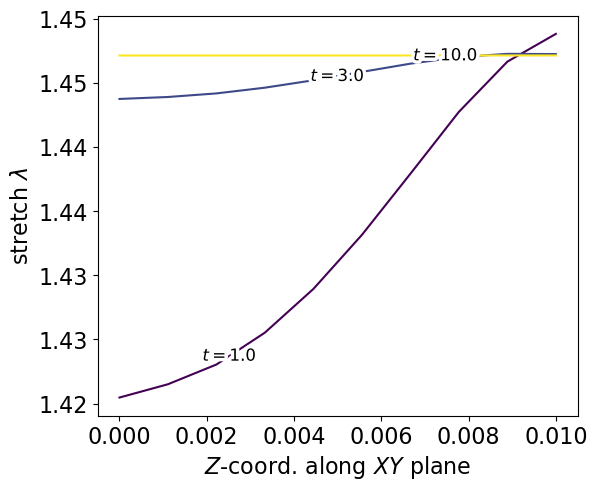

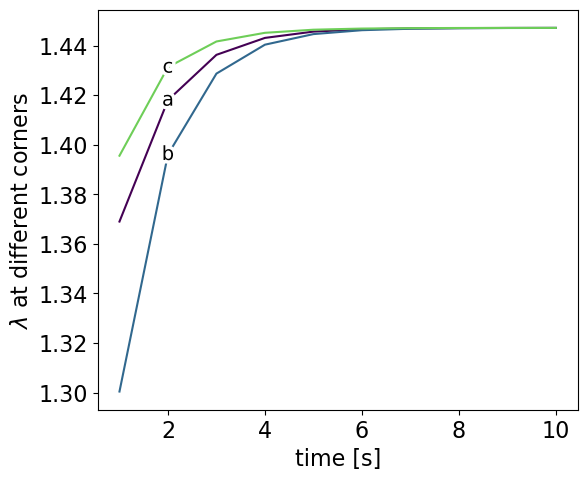

In [18]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines

# stretch
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[0]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

for n in [0,2,9]:
    ax.plot(x, Jx_array[:, n+1], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))


labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=12)
ax.set_xlabel("$Z$-coord. along $XY$ plane", fontsize=16)
ax.set_ylabel("stretch $\lambda$", fontsize=16)
# ax.legend(["reference 1D sol.", "2D FEM approx."], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda Jx_array, pos: "{:.2f}".format(Jx_array)))

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Liu/Fig_3DFEM_lambda_x001.pdf')

# stretch
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[1]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

print(lambda0_array.size)

ax.plot(t[1:], lambda0_array[0, 1:], color=colormap(normalize(0)), label="a")
ax.plot(t[1:], lambdaL_array[0, 1:], color=colormap(normalize(3)), label="b")
ax.plot(t[1:], lambdaL_array[-1, 1:], color=colormap(normalize(7)), label="c")

xvals = [2, 2, 2]
labelLines(ax.get_lines(), align=False, xvals=xvals, color="k", fontsize=14)
ax.set_xlabel("time [s]", fontsize=16)
ax.set_ylabel("$\lambda$ at different corners", fontsize=16)
# ax.legend(["bottom-left edge", "bottom-right edge", "top-left edge"], fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Liu/Fig_3DFEM_stretch_x001.pdf')